In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import glob as glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras import layers
import tensorflow as tf
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
from keras import ops

2025-05-08 10:12:27.509277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Processing

In [2]:
# Read in the shapefile for Maryland
shapefile_path = '/glade/derecho/scratch/dcalhoun/census/shapefiles/nhgis0001_shapefile_tl2023_us_tract_2023'
gdf = gpd.read_file(shapefile_path).to_crs('WGS84')
gdf = gdf[gdf['STATEFP'] == '24'][['GEOID', 'ALAND', 'INTPTLAT', 'INTPTLON', 'geometry']].reset_index(drop=True)
gdf['INTPTLAT'] = gdf['INTPTLAT'].astype('float')
gdf['INTPTLON'] = gdf['INTPTLON'].astype('float')
gdf['ALAND'] = gdf['ALAND'] / 1e6 # Convert to km^2
gdf.rename(columns={'GEOID': 'geo_id', 'INTPTLAT': 'latitude', 'INTPTLON': 'longitude', 'ALAND': 'land_area'}, inplace=True) # Rename columns
gdf.set_index('geo_id', inplace=True) # Set GEOID as the index
gdf.head()

,land_area,latitude,longitude,geometry
geo_id,,,,
24001000100,486.743629,39.636514,-78.509449,"POLYGON ((-78.34283 39.72226, -78.34273 39.722..."
24001000200,124.505957,39.612313,-78.703104,"POLYGON ((-78.61336 39.53717, -78.61337 39.537..."
24001000500,11.455399,39.654664,-78.729489,"POLYGON ((-78.71741 39.63624, -78.71742 39.636..."
24001000600,4.098568,39.640955,-78.739835,"POLYGON ((-78.71741 39.63624, -78.71742 39.636..."
24001000700,1.844978,39.632959,-78.752655,"POLYGON ((-78.7384 39.62725, -78.73849 39.6271..."


In [3]:
census_varnames = {
    "B02001_001": "Total population",
    "B02001_002": "White alone",
    "B02001_003": "Black alone",
    "B02001_004": "American Indian and Alaska Native alone",
    "B02001_005": "Asian alone",
    "B02001_006": "Native Hawaiian and other Pacific Islander alone",
    "B02001_007": "Some other race alone",
    "B02001_008": "Two or more races",
    "B03001_002": "Not Hispanic or Latino",
    "B03001_003": "Hispanic or Latino",
    "B15003_001": "Population 25 years and older",
    "B15003_017": "Regular high school diploma",
    "B15003_021": "Associate's degree",
    "B15003_022": "Bachelor's degree",
    "B15003_023": "Master's degree",
    "B15003_024": "Professional school degree",
    "B15003_025": "Doctorate degree",
    "B17001_001": "Population for whom poverty status is determined",
    "B17001_002": "Income in the past 12 months below poverty level",
    "B17001_031": "Income in the past 12 months at or above poverty level",
    "B23025_003": "Civilian labor force",
    "B23025_004": "Employed",
    "B23025_005": "Unemployed"
}

In [4]:
# Read in the census data
census_files = sorted(glob.glob('/glade/derecho/scratch/dcalhoun/census/data/acs_5yr_2023/tract/Maryland/*.csv'))
dataframes = []
df = None
for i, census_file in enumerate(census_files):
    if i != len(census_files) - 1:
        df = pd.read_csv(census_file)
        ncols = len(df.columns)
        df = pd.read_csv(census_file, usecols=range(ncols - 5))
        dataframes.append(df)
    else:
        df = pd.read_csv(census_file)
        dataframes.append(df)
df_census = pd.concat(dataframes, axis=1)

# Clean up the census data
df_census.drop(columns=['Unnamed: 0'], inplace=True) # Drop duplicate index column
df_census['geo_id'] = df_census['GEO_ID'].str.slice(-11) # Extract the shortened GEOID from the GEO_ID column
df_census.set_index('geo_id', inplace=True) # Set GEOID as the index
df_census.drop(columns=['GEO_ID'], inplace=True) # Drop the original GEO_ID column
cols = df_census.columns.tolist()
new_order = cols[-4:] + cols[:-4]
df_census = df_census[new_order] # Reorder columns
df_census.rename(columns={'NAME': 'name'}, inplace=True) # Rename columns

# Remove annotation columns
columns_to_drop = df_census.filter(regex='(EA|MA)$').columns
df_census.drop(columns=columns_to_drop, inplace=True)

# Extract estimates
drop_columns = ['name', 'state', 'county', 'tract']
df_census_estimates = df_census[[col for col in df_census.columns if col not in drop_columns and col.endswith('E')]].copy()
df_census_estimates.columns = df_census_estimates.columns.str[:-1]

columns_to_drop = df_census_estimates.columns[~df_census_estimates.columns.isin(list(census_varnames.keys()))] 
df_census_estimates.drop(columns=columns_to_drop, inplace=True) # Restrict to our columns of interest
df_census_estimates.rename(columns=census_varnames, inplace=True) # Rename columns

df_census_estimates = df_census_estimates.merge(gdf.copy()['land_area'], on='geo_id', how='left')

df_census_estimates.head()

,Total population,White alone,Black alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and other Pacific Islander alone,Some other race alone,Two or more races,Not Hispanic or Latino,Hispanic or Latino,...,Master's degree,Professional school degree,Doctorate degree,Population for whom poverty status is determined,Income in the past 12 months below poverty level,Income in the past 12 months at or above poverty level,Civilian labor force,Employed,Unemployed,land_area
geo_id,,,,,,,,,,,,,,,,,,,,,
24001000100,6403,5417,340,1,49,0,21,575,5820,583,...,203,31,0,3144,297,2847,1225,1137,88,486.743629
24001000200,2703,257,2295,0,18,0,95,38,2565,138,...,89,6,44,3031,364,2667,1297,1241,56,124.505957
24001000500,5248,312,3442,0,352,0,864,278,4155,1093,...,86,0,10,1864,528,1336,687,626,61,11.455399
24001000600,5268,148,4193,0,21,0,588,318,4426,842,...,197,0,24,2730,366,2364,1177,1141,36,4.098568
24001000700,4712,2161,1856,13,207,0,86,389,4106,606,...,106,13,13,3340,1136,2204,1414,1348,66,1.844978


In [5]:
df_census_data = pd.DataFrame()
df_census_data['population_density'] = df_census_estimates['Total population'] / df_census_estimates['land_area']
df_census_data['percent_white'] = df_census_estimates['White alone'] / df_census_estimates['Total population'] * 100
df_census_data['percent_black'] = df_census_estimates['Black alone'] / df_census_estimates['Total population'] * 100
df_census_data['percent_asian'] = df_census_estimates['Asian alone'] / df_census_estimates['Total population'] * 100
df_census_data['percent_other'] = (df_census_estimates['American Indian and Alaska Native alone'] + df_census_estimates['Some other race alone'] + df_census_estimates['Two or more races']) / df_census_estimates['Total population'] * 100
df_census_data['percent_hispanic'] = df_census_estimates['Hispanic or Latino'] / df_census_estimates['Total population'] * 100
df_census_data['percent_advanced'] = (df_census_estimates["Master's degree"] + df_census_estimates["Doctorate degree"] + df_census_estimates["Professional school degree"])/ df_census_estimates['Population 25 years and older'] * 100
df_census_data['percent_bachelors'] = df_census_estimates["Bachelor's degree"] / df_census_estimates['Population 25 years and older'] * 100
df_census_data['percent_associates'] = df_census_estimates["Associate's degree"] / df_census_estimates['Population 25 years and older'] * 100
df_census_data['percent_highschool'] = df_census_estimates['Regular high school diploma'] / df_census_estimates['Population 25 years and older'] * 100
df_census_data['percent_below_poverty'] = df_census_estimates['Income in the past 12 months below poverty level'] / df_census_estimates['Population for whom poverty status is determined'] * 100
df_census_data['unemployment_rate'] = df_census_estimates['Unemployed'] / df_census_estimates['Civilian labor force'] * 100

In [6]:
df_census_data

,population_density,percent_white,percent_black,percent_asian,percent_other,percent_hispanic,percent_advanced,percent_bachelors,percent_associates,percent_highschool,percent_below_poverty,unemployment_rate
geo_id,,,,,,,,,,,,
24001000100,13.154769,84.600968,5.310011,0.765266,9.323754,9.105107,9.256329,5.814873,13.607595,43.908228,9.446565,7.183673
24001000200,21.709805,9.507954,84.905660,0.665927,4.920459,5.105438,4.419714,7.376789,8.680445,35.548490,12.009238,4.317656
24001000500,458.124593,5.945122,65.586890,6.707317,21.760671,20.826982,6.813343,11.568488,3.122782,37.473385,28.326180,8.879185
24001000600,1285.326973,2.809415,79.593774,0.398633,17.198178,15.983295,10.838646,12.113781,15.497793,31.535066,13.406593,3.058624
24001000700,2553.959993,45.861630,39.388795,4.393039,10.356537,12.860781,6.000000,7.500000,9.863636,32.727273,34.011976,4.667610
...,...,...,...,...,...,...,...,...,...,...,...,...
24510280402,3455.507449,0.000000,94.332818,0.000000,5.667182,2.627512,2.996670,27.302997,7.769145,19.311876,15.681639,2.575107
24510280403,2338.711879,93.252393,0.000000,0.630399,6.117208,0.677095,23.430532,17.392796,5.180103,22.915952,10.799610,1.309329
24510280404,7491.536684,22.201258,60.660377,6.619497,10.518868,5.896226,7.022175,13.252376,6.388596,24.181626,22.195416,10.770578


In [7]:
# Define encoding of day of year as a cyclical feature
def encode_day_of_year(x):
    return np.sin(2 * np.pi * x / 365.0)

In [8]:
agg_files = sorted(glob.glob('/glade/derecho/scratch/dcalhoun/aggregated/tract/Maryland/ifs/0.125/t2m/00/24/*/*/*anom*.csv'))

In [9]:
dfs = []
for f in agg_files:
    df = pd.read_csv(f)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df['time'] = pd.to_datetime(df['time'])
df['dayofyear'] = encode_day_of_year(df['time'].dt.dayofyear)
df['GEOID'] = df['GEOID'].astype('str')
df.rename(columns={'GEOID': 'geo_id'}, inplace=True) # Rename columns
df.drop(columns=['time'], inplace=True)
df_error = df.set_index('geo_id', inplace=False)
df_error.head()

,t2m_abs_error_anom,dayofyear
geo_id,,
24001000100,-0.769019,0.034422
24001000200,-0.877400,0.034422
24001000500,-0.920051,0.034422
24001000600,-0.920051,0.034422
24001000700,-0.920051,0.034422


In [10]:
df_phys = df_error.copy().merge(gdf[['latitude','longitude']], on='geo_id').dropna()
data_phys = df_phys.values

In [11]:
df_full = df_phys.copy().merge(df_census_data, on='geo_id').dropna()
data_full = df_full.values

In [12]:
df_phys

,t2m_abs_error_anom,dayofyear,latitude,longitude
geo_id,,,,
24001000100,-0.769019,0.034422,39.636514,-78.509449
24001000200,-0.877400,0.034422,39.612313,-78.703104
24001000500,-0.920051,0.034422,39.654664,-78.729489
24001000600,-0.920051,0.034422,39.640955,-78.739835
24001000700,-0.920051,0.034422,39.632959,-78.752655
...,...,...,...,...
24510280402,0.285981,0.017213,39.299226,-76.690372
24510280403,0.240203,0.017213,39.285990,-76.703338
24510280404,0.257004,0.017213,39.287805,-76.691757


In [13]:
df_full

,t2m_abs_error_anom,dayofyear,latitude,longitude,population_density,percent_white,percent_black,percent_asian,percent_other,percent_hispanic,percent_advanced,percent_bachelors,percent_associates,percent_highschool,percent_below_poverty,unemployment_rate
geo_id,,,,,,,,,,,,,,,,
24001000100,-0.769019,0.034422,39.636514,-78.509449,13.154769,84.600968,5.310011,0.765266,9.323754,9.105107,9.256329,5.814873,13.607595,43.908228,9.446565,7.183673
24001000200,-0.877400,0.034422,39.612313,-78.703104,21.709805,9.507954,84.905660,0.665927,4.920459,5.105438,4.419714,7.376789,8.680445,35.548490,12.009238,4.317656
24001000500,-0.920051,0.034422,39.654664,-78.729489,458.124593,5.945122,65.586890,6.707317,21.760671,20.826982,6.813343,11.568488,3.122782,37.473385,28.326180,8.879185
24001000600,-0.920051,0.034422,39.640955,-78.739835,1285.326973,2.809415,79.593774,0.398633,17.198178,15.983295,10.838646,12.113781,15.497793,31.535066,13.406593,3.058624
24001000700,-0.920051,0.034422,39.632959,-78.752655,2553.959993,45.861630,39.388795,4.393039,10.356537,12.860781,6.000000,7.500000,9.863636,32.727273,34.011976,4.667610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24510280402,0.285981,0.017213,39.299226,-76.690372,3455.507449,0.000000,94.332818,0.000000,5.667182,2.627512,2.996670,27.302997,7.769145,19.311876,15.681639,2.575107
24510280403,0.240203,0.017213,39.285990,-76.703338,2338.711879,93.252393,0.000000,0.630399,6.117208,0.677095,23.430532,17.392796,5.180103,22.915952,10.799610,1.309329
24510280404,0.257004,0.017213,39.287805,-76.691757,7491.536684,22.201258,60.660377,6.619497,10.518868,5.896226,7.022175,13.252376,6.388596,24.181626,22.195416,10.770578


In [14]:
phys_scaler = StandardScaler()
data_phys_scaled =  phys_scaler.fit_transform(data_phys)

In [15]:
full_scaler = StandardScaler()
data_full_scaled =  full_scaler.fit_transform(data_full)

# ANN Autoencoder (PHYSICS)
Features: 
1. Absolute error
2. Day of year cyclical feature
3. Latitude
4. Longitude

In [16]:
keras.utils.set_random_seed(812)

In [17]:
# create fully connected autoencoder
model = keras.Sequential(name='autoencoder')

# input
model.add(keras.Input(shape=(4,), name='input')) # features

# encoder
# hidden layers
model.add(layers.Dense(16, activation="tanh", name='encoder'))

# desired dimensions
model.add(layers.Dense(2, activation="linear", name='bottleneck'))

# decoder
model.add(layers.Dense(16, activation="tanh", name='decoder'))

# Finally, we add last layer
model.add(layers.Dense(4, activation='linear', name='output')) # back to the original shape

# print model summary
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230 (920.00 B)

 Trainable params: 230 (920.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
# define list of metrics
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
    keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
]

# compile your nn
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

# set hyperparameters
BATCH_SIZE = 256
EPOCHS = 50

In [19]:
# train the NN now
history = model.fit(
    x=data_phys_scaled,
    y=data_phys_scaled,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/50
16896/16896 ━━━━━━━━━━━━━━━━━━━━ 16s 897us/step - loss: 0.2558 - mean_absolute_error: 0.3590 - mean_squared_error: 0.2558 - root_mean_squared_error: 0.4962 - val_loss: 0.1202 - val_mean_absolute_error: 0.2420 - val_mean_squared_error: 0.1202 - val_root_mean_squared_error: 0.3468
Epoch 2/50
16896/16896 ━━━━━━━━━━━━━━━━━━━━ 15s 897us/step - loss: 0.1217 - mean_absolute_error: 0.2393 - mean_squared_error: 0.1217 - root_mean_squared_error: 0.3489 - val_loss: 0.1070 - val_mean_absolute_error: 0.2195 - val_mean_squared_error: 0.1070 - val_root_mean_squared_error: 0.3271
Epoch 3/50
16896/16896 ━━━━━━━━━━━━━━━━━━━━ 16s 913us/step - loss: 0.1089 - mean_absolute_error: 0.2214 - mean_squared_error: 0.1089 - root_mean_squared_error: 0.3300 - val_loss: 0.1017 - val_mean_absolute_error: 0.2131 - val_mean_squared_error: 0.1017 - val_root_mean_squared_error: 0.3189
Epoch 4/50
16896/16896 ━━━━━━━━━━━━━━━━━━━━ 15s 895us/step - loss: 0.1031 - mean_absolute_error: 0.2144 - mean_squared_error: 0

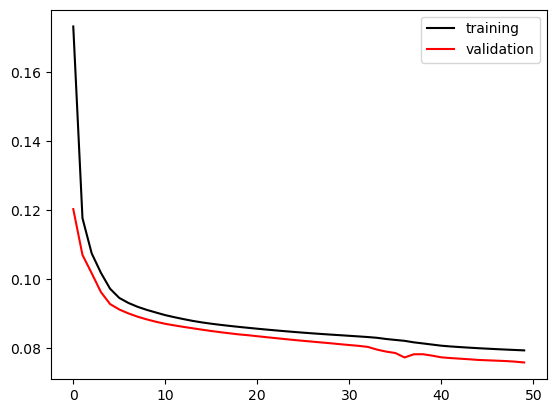

In [20]:
# visualize training and validation curves
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

In [21]:
# evaluation mode
data_pred_phys = model.predict(data_phys_scaled)

150187/150187 ━━━━━━━━━━━━━━━━━━━━ 62s 411us/step


In [23]:
data_pred_phys_inv = phys_scaler.inverse_transform(data_pred_phys)

NameError: name 'data_pred_phys' is not defined

In [ ]:
# Predicted vs actual
plt.scatter(data_pred_phys_inv[:,0], data_phys[:,0])
a = 11
plt.xlim([-a,a])
plt.ylim([-a,a])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Physics only: error anom recontruction')
plt.show()

In [ ]:
np.sqrt(1/len(data_phys[:,0]) * np.sum((data_phys[:,0] - data_pred_phys_inv[:,0])**2))

In [ ]:
# we define the input layer to the ANN and the output of the bottleneck layer
bottleneck = tf.keras.Model(
    inputs=model.layers[0].input,
    outputs=model.layers[1].output
    )

In [ ]:
# input test data into the bottleneck function
bottleneck_output = np.array(bottleneck(data_phys_scaled))

In [ ]:
bottleneck_output.shape

In [ ]:
bottleneck_output.shape

In [ ]:
# we can visualize what these two nodes in the bottleneck output
plt.scatter(bottleneck_output[:,0],bottleneck_output[:,1])
plt.show()

# ANN Autoencoder (PHYSICS + CENSUS)
Features: 
1. Absolute error
2. Day of year cyclical feature
3. Latitude
4. Longitude
5. Population desnity

In [24]:
# create fully connected autoencoder
model = keras.Sequential(name='autoencoder')

# input
model.add(keras.Input(shape=(16,), name='input')) # features

# encoder
# hidden layers
model.add(layers.Dense(16, activation="tanh", name='encoder'))

# desired dimensions
model.add(layers.Dense(2, activation="linear", name='bottleneck'))

# decoder
model.add(layers.Dense(16, activation="tanh", name='decoder'))

# Finally, we add last layer
model.add(layers.Dense(16, activation='linear', name='output')) # back to the original shape

# print model summary
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 16)             │           272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626 (2.45 KB)

 Trainable params: 626 (2.45 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# define list of metrics
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
    keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
]

# compile your nn
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

# set hyperparameters
BATCH_SIZE = 256
EPOCHS = 50

In [26]:
# train the NN now
history = model.fit(
    x=data_full_scaled,
    y=data_full_scaled,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/50
16654/16654 ━━━━━━━━━━━━━━━━━━━━ 16s 916us/step - loss: 0.5583 - mean_absolute_error: 0.5292 - mean_squared_error: 0.5583 - root_mean_squared_error: 0.7456 - val_loss: 0.4310 - val_mean_absolute_error: 0.4865 - val_mean_squared_error: 0.4310 - val_root_mean_squared_error: 0.6565
Epoch 2/50
16654/16654 ━━━━━━━━━━━━━━━━━━━━ 15s 921us/step - loss: 0.4317 - mean_absolute_error: 0.4853 - mean_squared_error: 0.4317 - root_mean_squared_error: 0.6570 - val_loss: 0.4071 - val_mean_absolute_error: 0.4755 - val_mean_squared_error: 0.4071 - val_root_mean_squared_error: 0.6381
Epoch 3/50
16654/16654 ━━━━━━━━━━━━━━━━━━━━ 15s 903us/step - loss: 0.4122 - mean_absolute_error: 0.4753 - mean_squared_error: 0.4122 - root_mean_squared_error: 0.6420 - val_loss: 0.4017 - val_mean_absolute_error: 0.4728 - val_mean_squared_error: 0.4017 - val_root_mean_squared_error: 0.6338
Epoch 4/50
16654/16654 ━━━━━━━━━━━━━━━━━━━━ 15s 896us/step - loss: 0.4080 - mean_absolute_error: 0.4732 - mean_squared_error: 0

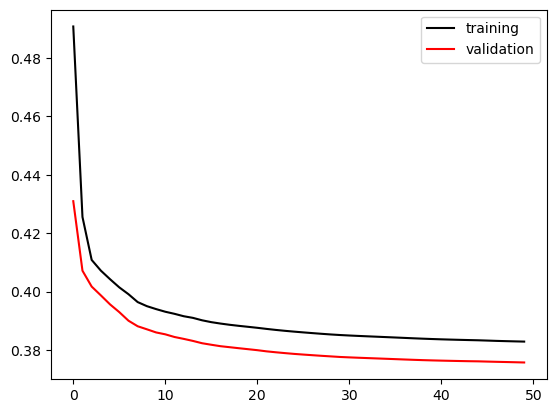

In [27]:
# visualize training and validation curves
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

In [28]:
# evaluation mode
data_pred_full = model.predict(data_full_scaled)

148031/148031 ━━━━━━━━━━━━━━━━━━━━ 64s 433us/step


In [31]:
data_pred_full_inv = full_scaler.inverse_transform(data_pred_full)

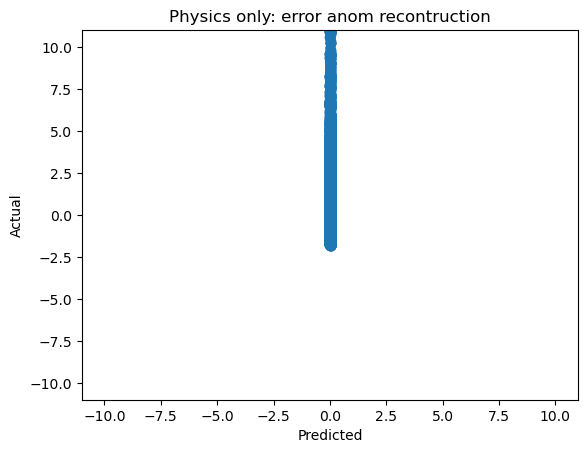

In [32]:
# Predicted vs actual
plt.scatter(data_pred_full_inv[:,0], data_full[:,0])
a = 11
plt.xlim([-a,a])
plt.ylim([-a,a])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Physics only: error anom recontruction')
plt.show()

In [33]:
np.sqrt(1/len(data_full[:,0]) * np.sum((data_full[:,0] - data_pred_full_inv[:,0])**2))

0.9765621667505555

In [34]:
# we define the input layer to the ANN and the output of the bottleneck layer
bottleneck = tf.keras.Model(
    inputs=model.layers[0].input,
    outputs=model.layers[1].output
    )

In [35]:
# input test data into the bottleneck function
bottleneck_output = np.array(bottleneck(data_full_scaled))

In [36]:
bottleneck_output.shape

(4736970, 2)

In [37]:
bottleneck_output.shape

(4736970, 2)

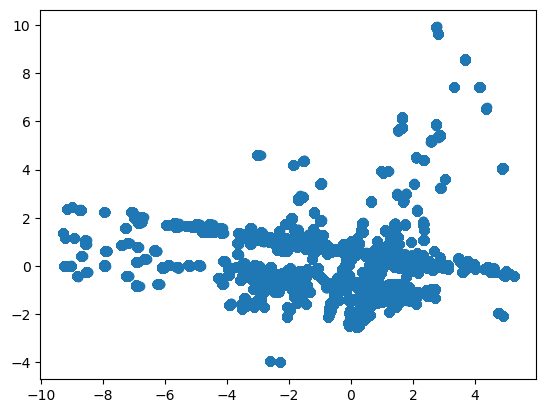

In [38]:
# we can visualize what these two nodes in the bottleneck output
plt.scatter(bottleneck_output[:,0],bottleneck_output[:,1])
plt.show()